# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is the Mahomet Aquifer in Illinois, particulary in the heavily irrigated region of Mason County. 

Note that you may not always have to compile MODFLOW, and you only have initialize code (#1) and import large files (#2) the first time you run the code in a session. Most of the time, you will only have to run #3 onward. 

# 0. Compile MODFLOW (DO NOT RUN UNLESS NECESSARY)


When using Google CoLab, you cannot simply use an existing MODFLOW executable, but have to compile a a new one for use in this environment. I have already compiled MODFLOW, but am currently unsure if it will work for everybody. Please do not run the following code unless you get an error that the MODFLOW file was not found (will occur when running the model). 

In [0]:
#!pip install https://github.com/modflowpy/pymake/zipball/master # install of the pymake package to compile MODFLOW

In [0]:
# Code to complile the MODFLOW executable

#import pymake

#def make_mf2005():
#    pymake.build_apps('mf2005')


#if __name__ == "__main__":
#    make_mf2005()



#MF-NWT has more robust handling of dry cells

#import pymake

#def make_mfnwt():
#    pymake.build_apps('mfnwt')

#if __name__ == "__main__":
#    make_mfnwt()


# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages
There are three packages that must be installed in the CoLab environment to run this script. These include 

"pyproj", which allows for the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

"flopy" creates modflow executables, runs the model, and allows for manipulation of results.

"rasterio" allows for the reading of raster files, and is closely tied to the development of "flopy" input files


In [1]:
!pip install pyproj
!pip install flopy
!pip install rasterio
!pip install pykrige
!pip install metpy
!apt-get -qq install python-cartopy python3-cartopy

## 1B. Import packages

In [2]:
import flopy # import flopy to develop, run, and analyze the model
from flopy.utils import Raster # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import pyproj # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import cartopy
import cartopy.crs as ccrs # import projections
import cartopy.feature as cf # import features
from pykrige.uk import UniversalKriging
import pylab # using as a plotting library for spatial data, make contours
from metpy.plots import USCOUNTIES

# the following code authorizes you to access files on Google Drive
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials


flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


## 1C. Authenticate with Google
This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive

Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

#downloaded = drive.CreateFile({'id':"1iThxRoGVhofLPd8HOF7Vn0awRVrXZcVb"}) # This is the key that is defined in the sharable link of a file on Google Drive
#downloaded.GetContentFile('mfnwt') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

#!cp mfnwt /usr/local/bin
#!chmod 755 /usr/local/bin/mfnwt

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

In [0]:
# first import the land surface .tif from Google Drive
downloaded = drive.CreateFile({'id':"1389l8sgQ8-tsmIZuZosaqvbqpHY40n6l"}) # ft above msl
downloaded.GetContentFile('landsurface_el.tif')

# first import the bedrock elevation .tif from Google Drive
downloaded = drive.CreateFile({'id':"1EZgZDjjILzvRzvY9nf0Qp0NHmspRq4kP"})   
downloaded.GetContentFile('bedrock_el.tif')

# read in percent thickness of coarse grain for each model layer
downloaded = drive.CreateFile({'id':"18Kw3O6qCzIJ2L6KrVnRPIhea_F8VwyWn"})   
downloaded.GetContentFile('percentl1.tif')

downloaded = drive.CreateFile({'id':"1oZinFPKrGY-FXoE7Zu0okFpAAOe_bwau"})   
downloaded.GetContentFile('percentl2.tif')

downloaded = drive.CreateFile({'id':"1FqVEr4m_ElUyEZeyfnCMwVGDfUqavJZH"})   
downloaded.GetContentFile('percentl3.tif')

downloaded = drive.CreateFile({'id':"1KiHS9TLSP1GAVTjaaJZS4BAwF6gnUeDu"})   
downloaded.GetContentFile('percentl4.tif')

downloaded = drive.CreateFile({'id':"1Z-9EyaAK1NKnRHAlnyGYkI3suvBFC2I6"})   
downloaded.GetContentFile('percentl5.tif')

downloaded = drive.CreateFile({'id':"1pcB9aJpJGfkXOKz10rhs6MpWkQL1_dqr"})   
downloaded.GetContentFile('percentl6.tif')

downloaded = drive.CreateFile({'id':"1Fnh0HIKbUj7pEtlsUKR_Sr7WwfYzWul5"})   
downloaded.GetContentFile('percentl7.tif')

downloaded = drive.CreateFile({'id':"106JacgpwSA3wVAGcBIzGdc8rDVUB6dh7"})   
downloaded.GetContentFile('percentl8.tif')

downloaded = drive.CreateFile({'id':"1WJjhVJ_KSBhZDrgzY3YteNjxaz5nxBid"})   
downloaded.GetContentFile('percentl9.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Model Set-up

### 3Ai. Define the Model Domain

In [8]:
#----------------------------------------------------------------------------
# Define model domain in lat/long coordinates

# Will County coordinates for each corner of the domain
sw_lat =  41.41 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.73 #northeast latitude
ne_long = -88.03 #northeast longitude

'''
# Northern section
sw_lat =  41.57 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.73 #northeast latitude
ne_long = -88.03 #northeast longitude
'''

'''
# Southern section
sw_lat =  41.41 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.57 #northeast latitude
ne_long = -88.03 #northeast longitude
'''

illimap = {'proj': 'lcc', # code for Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap) # Define "prj" as the illimap coordinate system

wgs84 = pyproj.Proj("epsg:4326") # Define "wgs84" as the EPSG 4326 / WGS84 coordinate system.  Note that WGS84 and EPSG 4326 are equivalent.

# Transform the coordinates of the NE and SW corners from WGS84 (lat and long) to Illimap (x and y)
nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)

nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4) # convert nex, ney from m to ft and round 
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4) # convert swx, swy from m to ft and round

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


### 3Aii. Define spatial and temporal discretization

In [0]:
# Assign Discretization variables
# Lx and Ly are in feet, converted in the previous code block
Lx = nex-swx # Width of the model domain in feet
Ly = ney-swy # Height of the model domain in feet
nlay = 10 # Number of model layers
dx = 2000 
dy = 2000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state


### 3Aiii. Define river elevations



In [0]:
# import river stage, lambert x, lambert y from river Excel file
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0 #this actually assigns it to layer 1
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 90000. # ft^2/d (this value was adjusted during calibration)
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded columns
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

# group duplicate rivers within a cell
dfriv = dfriv.groupby(['lay','row','col'],as_index=False).mean()

### 3Aiv. Define top and bottom elevations

In [0]:
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("landsurface_el.tif")
bedrock = Raster.load("bedrock_el.tif")

# Crop the DEM to the model domain
illinoisdem.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
bedrock.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
# Define centroid of the southwestern most cell
startx = swx+dx/2 
starty = swy+dy/2
# Calculate the x and y coordinates for the centroid of each cell 
xc = np.arange(swx+dx/2,nex+dx/2,dx) 
yc = np.arange(swy+dy/2,ney+dy/2,dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc,yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr,yarr,1,method='nearest') 
bedrock = bedrock.resample_to_grid(xarr,yarr,1,method='nearest')

# We built our top elevation upside down, let's flip it
topgrid = np.flipud(topgrid) 
bedrockgrid = np.flipud(bedrock)   

# Create ibound as array of ints (1), indicating all cells are active
# inactivate cells west of the Mississippi River that were originally not present
# note that because inactive cells would overlap with the river boundaries, this code pushes inactive cells to the west a bit. Adjust per your model domain
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Set the top of Layer 1 = River Elevation
for index, row in dfriv.iterrows():  
    topgrid[int(row['row']),int(row['col'])]=row['stage'] 
    #print(topgrid[int(row['row']),int(row['col'])],row['bot'])  

# make sure that all layers (combined) are at least 9 ft thick
diff = topgrid-bedrockgrid

diff[diff<=9.0] = 9.0

# each layer EXCEPT BEDROCK is the same thickness, we need 9 glacial layers
laythick = diff/9 #glacial layers
bothick = 50. #thickness of bedrock. May need to change?? look at report?

#calculate bottom of each layer
lay1bot = topgrid-laythick
lay2bot = topgrid-2*laythick
lay3bot = topgrid-3*laythick
lay4bot = topgrid-4*laythick
lay5bot = topgrid-5*laythick
lay6bot = topgrid-6*laythick
lay7bot = topgrid-7*laythick
lay8bot = topgrid-8*laythick
lay9bot = topgrid-9*laythick
lay10bot = lay9bot-bothick 

botgrids = [lay1bot,lay2bot,lay3bot,lay4bot,lay5bot,lay6bot,lay7bot,lay8bot,lay9bot,lay10bot]

### 3Av. Assign hydraulic conductivity

In [0]:
# assign hydraulic conductivity in ft/day
kc = 280 # predominantly coarse
kf = .3 # predominantly fine; maybe too high?
kb = 20 # bedrock

# determine how to assign hydrualic conductivity
threshold = 19 # anything above this will be assigned kc; anything below will be assigned kf

def kloader(rastername, kc, kf, threshold):
  percent = Raster.load(rastername) # load raster
  percent.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)]) # crop array
  percentgrid = percent.resample_to_grid(xarr,yarr,1,method='nearest') # resample to model grid
  percentgrid = np.flipud(percentgrid) # flip the grid
  maxrow = percentgrid.shape[0]
  maxcol = percentgrid.shape[1]
  for row in np.arange(maxrow,0,-1):
    for col in np.arange(maxcol,0,-1):
      if percentgrid[row-1,col-1] < -10:
        percentgrid[row-1,col-1] = percentgrid[row-1,col]
  percentgrid[percentgrid>=threshold] = kc # assign coarse k value
  percentgrid[percentgrid<threshold] =kf # assign fine k value
  return percentgrid

kl1 = kloader('percentl1.tif',kc,kf,threshold)
kl2 = kloader('percentl2.tif',kc,kf,threshold)
kl3 = kloader('percentl3.tif',kc,kf,threshold)
kl4 = kloader('percentl4.tif',kc,kf,threshold)
kl5 = kloader('percentl5.tif',kc,kf,threshold)
kl6 = kloader('percentl6.tif',kc,kf,threshold)
kl7 = kloader('percentl7.tif',kc,kf,threshold)
kl8 = kloader('percentl8.tif',kc,kf,threshold)
kl9 = kloader('percentl9.tif',kc,kf,threshold)
kl10 = kl9-kl9+kb

khlayers = [kl1,kl2,kl3,kl4,kl5,kl6,kl7,kl8,kl9,kl10]
kvlayers=np.divide(khlayers,10.)

### 3Avi. Define wells

In [0]:
# import well data from csv file
dfwel = pd.read_csv('https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/master/pumping/2002_pumping_V2.csv?token=AOLJKYWGS4UU7TGLSVCH6MK637FWA')
dfwel = dfwel.set_index('p_num') #assign index as p_number so that other columns can be deleted

# trim dataframe with well information to the model domain
dfwel = dfwel.loc[dfwel['lam_x']<nex]
dfwel = dfwel.loc[dfwel['lam_y']<ney]
dfwel = dfwel.loc[dfwel['lam_x']>swx]
dfwel = dfwel.loc[dfwel['lam_y']>swy]

# put the data into the format required for the well package, with columns for layer, row, column, and flux
# assign all wells to bedrock layer (10 layers but starts at 0 so the last layer is 9)
dfwel['lay'] = 9
# convert lamx to column and lamy to row
dfwel['row'] = np.trunc((ney-dfwel['lam_y'])/dy)
dfwel['col'] = np.trunc((dfwel['lam_x']-swx)/dx)
# define the flux as the pumpage data from the imported file and convert from gal/year to ft3/day to match other units of the model. Negative pumpage denotes removal of water from the system.
dfwel['flux']=dfwel['2002']*-1/2730.39

# drop unneeded columns
dfwel = dfwel.drop(['isws_facility_id','owner','fac_well_num','depth_total_last_known','lam_x','lam_y','2002'], axis=1)

#print(dfwel)

###3Avii. Define drains

In [15]:
# Add cells to the drain package wherever low-k material is at land surface.  These are cells in layer 1 with hydraulic conductivity k = kf.
# Create two arrays, one for rows and one for columns, corresponding to the row and column #s of elements in kl1 where k = kf.
rows,cols = np.nonzero(kl1==kf)

# Create a dataframe of the same length as "rows" called "dfdrn".  "dfdrn" includes a single column of zeros called "lay" which assigns all drain cells to the first layer
dfdrn = pd.DataFrame(np.zeros((len(rows), 1)),columns=['lay'])

# Add in the drain cell row and column #s
dfdrn['row'] = rows 
dfdrn['col'] = cols

# Add in a column for tracking overlap of drain and river cells
# 0 indicates the cell is not a river cell, while 1 indicates the cell is a river cell
# This column is initialized as containing only zeros
dfdrn['river?'] = np.zeros(len(dfdrn))

dfdrn_initial=len(dfdrn)

# Print the initial length of the drain dataframe
print('The initial length of the drain dataframe is',dfdrn_initial)

# The following lines of code ensures that no river cells are included in the drain package
# If any river cells were added to "dfdrn", the following lines of code will remove them

# Search through the "dfriv" and "dfdrn" dataframes to dentify any cells in "dfdrn" that correspond to river cells
for i in range(len(dfriv)):
  for j in range(len(dfdrn)):
    if dfriv.loc[i,'row'] == np.float64(dfdrn.loc[j,'row']) and dfriv.loc[i,'col'] == np.float64(dfdrn.loc[j,'col']):
      dfdrn.at[j,'river?'] = 1 # setting the value in the "river?" column to 1 denotes this cell as a river cell

# Remove any cells from "dfdrn" that were identified as river cells
dfdrn=dfdrn.loc[dfdrn['river?']==0]

# Drop the "river?" column, as it is no longer needed
dfdrn=dfdrn.drop('river?',axis=1)

# Reset the index of "dfdrn" to the default
dfdrn=dfdrn.reset_index(drop=True)

dfdrn_final=len(dfdrn)

# Print the final length of the drain dataframe
print('The final length of the drain dataframe is',dfdrn_final)

# Print the number of items removed, for reference
print(dfdrn_initial-dfdrn_final,'items were removed')

# Define the elevation of the drain cells (set to land surface elevation)
for value in dfdrn.index:
  dfdrn.loc[value,'elevation'] = topgrid[dfdrn.loc[value,'row'],dfdrn.loc[value,'col']]

# Define the conductance of the drain cells
#drains['cond'] = kf*100*(dx+dy)*0.3048/1.5 # 2 orders of magnitude higher than kf (ft^2/d). kf is in ft/d, so multiply by the mean of dx & dy (*0.3048 ft/m)
dfdrn['cond'] = kf*dx*dy/3 # This is the conductance between the cell and the drain, in ft^2/d.  This line of code is similar to the one above, but corrected to include A=dx*dy and remove the 0.3048 m/ft conversion factor
# For more information regarding the equation for conductance, see the "Notes on the conductance of drain cells" comment below.

# Notes on the conductance of drain cells
# C=K*dx*dy/delta ; C=K*dx*dy/b
# K is the conductivity of the soil layer.  K is defined as two orders of magnitude greater than kf; the soil layer is assumed to be more weathered than the underlying material.
# delta or b is the depth of the soil layer
# Out of a handful of randomly selected well logs, the depth of the uppermost soil layer (where present) varied significantly.
# For simplicity, the soil layer is assumed to have a thickness of 3 feet, uniform throughout the model.

#print(dfdrn)

The initial length of the drain dataframe is 1492
The final length of the drain dataframe is 1312
180 items were removed


## 3B. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.
modelname = "my_model" # name the model
m = flopy.modflow.Modflow(modelname, version = 'mf2005', exe_name = 'mf2005') # create model object m

## 3C. Append the discretization package to the model object

In [0]:
# length and time are in feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

## 3D. Basic Package

In [0]:
# Create ibound as array of ints (1), indicating all cells are active
#ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)


## 3E. LPF Package

In [0]:
# Define layer type as convertible (1), must be an integer
# For more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = 0*np.ones((nlay,), dtype=np.int32)

# Create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=khlayers, vka=kvlayers, laytyp=laytyp, ipakcb=1)


## 3F. Boundary Conditions

### 3Fi. Recharge Package

In [0]:
# Assign recharge to the model
#units=ft/d

rch1=0.0014 #fine
rch2=0.0024 #coarse

# Create a recharge array based on values in kl1 (the top layer)
# Cells where kl1 = kf are assigned recharge = rch1
# All other cells (where kl1 = kc) are assigned recharge = rch2
recharge=np.where(kl1<=kf, rch1, rch2) 

# Create the recharge package (RCH)
rch = flopy.modflow.mfrch.ModflowRch(model=m, ipakcb=1, nrchop=3, rech = recharge)
#ipakcb=1 signals that cell-by-cell budget data should be saved
#nrchop=3 assigns recharge to the uppermost active cell in each column

### 3Fii. River Package

In [0]:
# Put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv} #dictionary assigning river data; key (0) is the stress period

# Create the river package (RIV)
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=1, stress_period_data = riverdata)
#ipakcb=1 signals that cell-by-cell budget data should be saved

### 3Fiii. Drain Package


In [0]:
# Put into a format that MODFLOW wants
ardrn = dfdrn.values
draindata = {0: ardrn} # Here, "draindata" functions similarly to "riverdata" in the previous code block

# Create the drain package (DRN)
drn = flopy.modflow.mfdrn.ModflowDrn(model=m, ipakcb=1, stress_period_data = draindata)
#ipakcb=1 signals that cell-by-cell budget data should be saved

### 3Fiv. Well Package

In [0]:
# put into a format that MODFLOW wants as a dictionary with the values from the well dataframe created in the section above.
arwell = dfwel.values
welldata = {0: arwell} # Here, "welldata" functions similarly to "riverdata" and "draindata" in the previous code blocks

# Create the well package (WEL)
wel = flopy.modflow.mfwel.ModflowWel(model=m, ipakcb=1, stress_period_data = welldata)
#ipakcb=1 signals that cell-by-cell budget data should be saved

### 3G. Define output control

In [0]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 3H. Solver

In [0]:
# We will start by using the PCG solver with default settings
#pcg = flopy.modflow.ModflowPcg(model=m)
pcg = flopy.modflow.ModflowPcg(model=m,mxiter=200,iter1=50,hclose=1e-03,rclose=1e-03,relax=0.98,damp=0.3)

## 3I. Plot model inputs (boundary conditions, elevations)

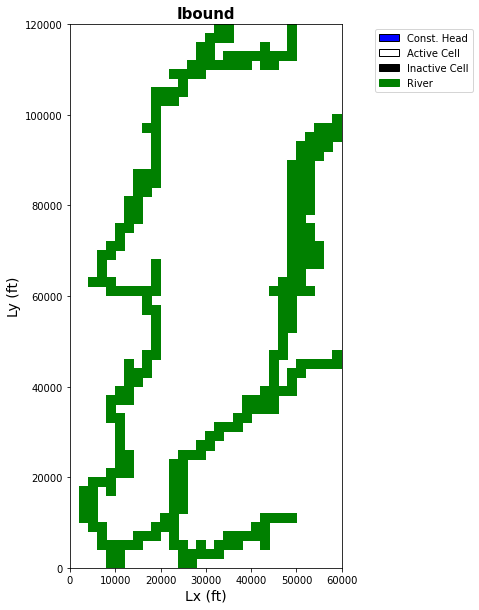

In [26]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='green',label='River',ec='green')],
                   bbox_to_anchor=(1.5,1.0))
plt.show()
#----------------------------------------------------------------------------

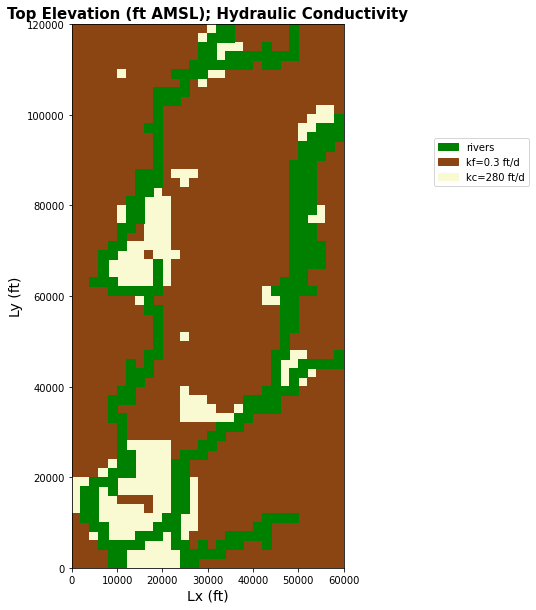

In [27]:
'''Plot hydraulic conductivity'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#contour_levels = np.linspace(400,800,41)
#topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
#plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')

#create colormap of named colors
colors = ["saddlebrown","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
modelmap.plot_array(khlayers[0],norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL); Hydraulic Conductivity', fontsize = 15, fontweight = 'bold')

#Create a legend for the hydraulic conductivity
plt.legend(handles=[
  mp.patches.Patch(color='green', label='rivers'),
  mp.patches.Patch(color='saddlebrown', label='kf=0.3 ft/d'),
  mp.patches.Patch(color='lightgoldenrodyellow', label='kc=280 ft/d') ], bbox_to_anchor=(1.7,0.8))
plt.show()

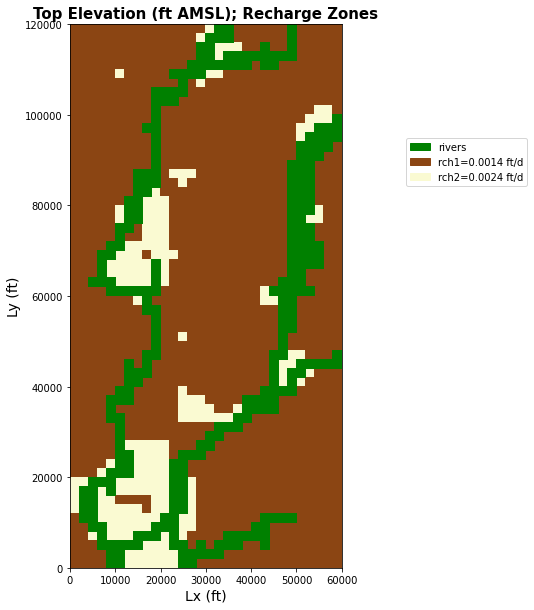

In [28]:
'''Plot recharge'''
#----------------------------------------------------------------------------
fig=plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#contour_levels = np.linspace(400,800,41)
#topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
#plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')

#create colormap of named colors
colors = ["saddlebrown","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=rch1,vmax=rch2)
pcm=modelmap.plot_array(recharge, norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL); Recharge Zones', fontsize = 15, fontweight = 'bold')

#Create a legend for the recharge zones 
plt.legend(handles=[
  mp.patches.Patch(color='green', label='rivers'),
  mp.patches.Patch(color='saddlebrown', label='rch1=0.0014 ft/d'),
  mp.patches.Patch(color='lightgoldenrodyellow', label='rch2=0.0024 ft/d') ], bbox_to_anchor=(1.7,0.8))
plt.show()

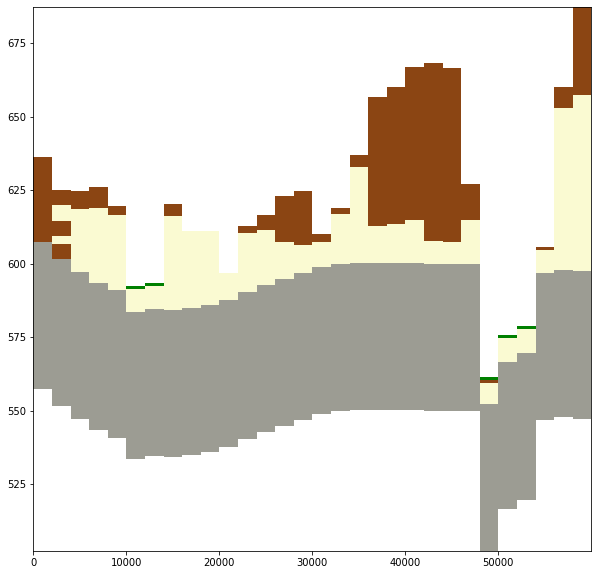

In [29]:
'''Plot transects'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelxsect = flopy.plot.PlotCrossSection(model = m, line={"row":22}) #use plotmapview to attach plot to model. row indicates west to east 
#modelxsect = flopy.plot.PlotCrossSection(model = m, line={"column":15}) #plots north-south transect
#create colormap of named colors
colors = ["saddlebrown","gray","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
#modelxsect.plot_grid()
khlaynp = np.array(khlayers)
lines = modelxsect.plot_array(khlaynp,norm=norm, cmap=cmap)
rvr = modelxsect.plot_bc(ftype='RIV')
modelxsect.plot_ibound()

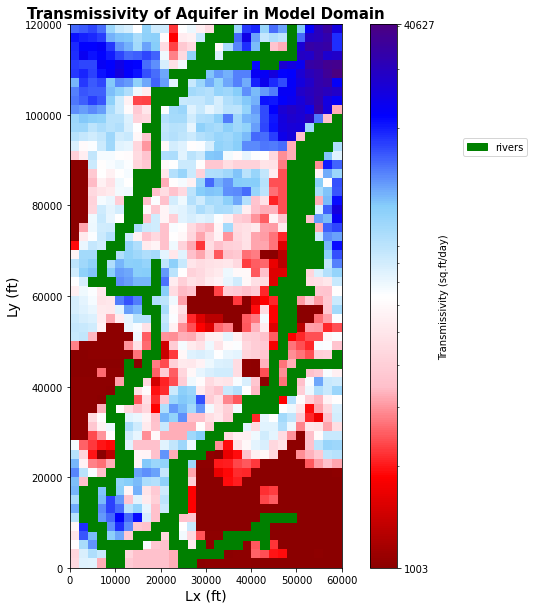

In [30]:
'''Plot Transmissivity'''
# horizontal T = sum(k*b), for each layer.  k is the hydraulic conductivity, and b is the layer thickness
Thz=sum([k for k in khlayers])*laythick-kl10*laythick+kl10*bothick
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model

# create colormap of named colors
colors = ["darkred","red","pink","white","lightskyblue","blue","indigo"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=np.amin(Thz),vmax=np.amax(Thz))
Tmap=modelmap.plot_array(Thz,norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
# display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Transmissivity of Aquifer in Model Domain', fontsize = 15, fontweight = 'bold')
cbar=plt.colorbar(Tmap,ticks=[np.amin(Thz),np.amax(Thz)], label='Transmissivity (sq.ft/day)')
cbar.set_ticklabels([int(round(np.amin(Thz),0)),int(round(np.amax(Thz),0))])
plt.legend(handles=[mp.patches.Patch(color='green', label='rivers')], bbox_to_anchor=(1.7,0.8))
plt.show()

# 4 Write and run the MODFLOW model

In [31]:
# write the model input
m.write_input()

# execute the model run
success, mfoutput = m.run_model(pause=False, report=True)

# report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/06/04  1:37:08

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/06/04  1:37:09
 Elapsed run time:  1.832 Seconds

  Normal termination of simulation


# 5 Plot Output Data

In [0]:
'''Extract binary data from head and flow files'''
#----------------------------------------------------------------------------
# extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')

# extract head data from head object
head = headobj.get_data(totim=1.0)

#print(head[9]) #returns heads in the bottom layer, where pumping occurs


/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


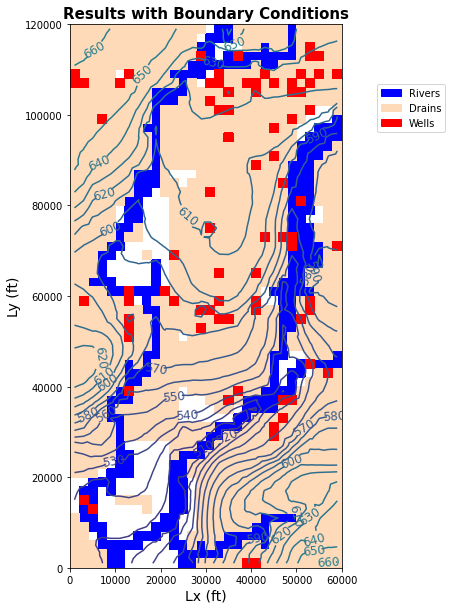

In [33]:
'''Plot results with boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
contour_levels = np.linspace(400,1000,61) #set contour levels for contouring head
head_contours = modelmap.contour_array(head[9], levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
rvr = modelmap.plot_bc(ftype='RIV',color="blue")
drn_map = modelmap.plot_bc(ftype='DRN', color='peachpuff')
wel_map = modelmap.plot_bc(ftype='WEL',plotAll=True) #plot well locations in the model domain, shown on the top layer for visibility

# display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Results with Boundary Conditions', fontsize = 15, fontweight = 'bold')

# create a legend for the boundary conditions
plt.legend(handles=[
  mp.patches.Patch(color='blue', label='Rivers'),
  mp.patches.Patch(color='peachpuff', label='Drains'),
  mp.patches.Patch(color='red', label='Wells') ], bbox_to_anchor=(1.4,0.9))

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


Text(0.5, 1.0, 'Steady-State Model Head(ft) Results')

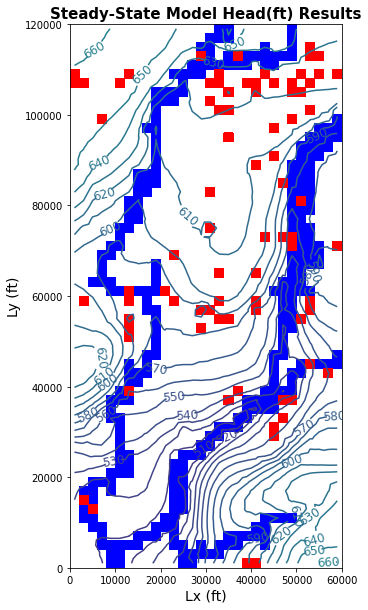

In [34]:
# plot potentiometric surface results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
contour_levels = np.linspace(400,1000,61) #set contour levels for contouring head with 61 values from 400-1000
head_contours = modelmap.contour_array(head[9], levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
rvr = modelmap.plot_bc(ftype='RIV',color="blue")
wel_map = modelmap.plot_bc(ftype='WEL',plotAll=True) #plot well locations in the model domain, shown on the top layer for visibility

# display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Steady-State Model Head(ft) Results', fontsize = 15, fontweight = 'bold')

# 6 Calibration

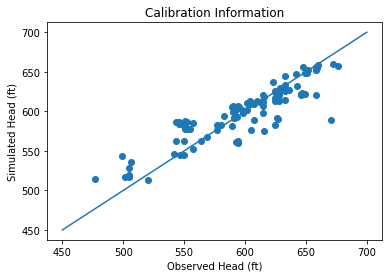

In [53]:
# import the observation well data as a dataframe
# "SB_Potent_Surface_points.csv"
pumping_ob = pd.read_csv('https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/master/pumping/SB_Potent_Surface_points.csv?token=AOLJKYREDLX63LT65W4GH5263O4W4')

# trim the dataframe to the model domain
pumping_ob = pumping_ob.loc[pumping_ob['lambx']<nex]
pumping_ob = pumping_ob.loc[pumping_ob['lamby']<ney]
pumping_ob = pumping_ob.loc[pumping_ob['lambx']>swx]
pumping_ob = pumping_ob.loc[pumping_ob['lamby']>swy]

# reset the dataframe index to the default
pumping_ob=pumping_ob.reset_index(drop=True)

# convert lambx to column and lamby to row, and convert to grid format
pumping_ob['row'] = np.trunc((ney-pumping_ob['lamby'])/dy)
pumping_ob['col'] = np.trunc((pumping_ob['lambx']-swx)/dx)

# convert rows and columns to integers
pumping_ob['row'] = pumping_ob.row.astype("int64")
pumping_ob['col'] = pumping_ob.col.astype("int64")

# create a new column, containing head values simulated by the model
pumping_ob['simulated']=head[9,pumping_ob['row'],pumping_ob['col']]

# compare the observed to simulated head data
compare=pumping_ob
compare=compare.set_index('Head_ftAMS')
compare=compare.drop(['lambx','lamby','row','col'],axis=1)
#print(compare)

# create a scatterplot of simulated heads versus observed heads
plt.scatter(compare.index,compare.simulated)
x = np.linspace(450,700)
y = x
plt.plot(x,y) #create x=y line to compare
plt.xlabel('Observed Head (ft)')
plt.ylabel('Simulated Head (ft)')
plt.title('Calibration Information')
plt.show()

In [56]:
# calculate mean and mean absolute error
pumping_ob['error']=pumping_ob['Head_ftAMS']-pumping_ob['simulated'] #difference between observed and simulated head
pumping_ob['absolute']=pumping_ob.error.abs() #calculate absolute error, in ft
mean=pumping_ob.error.mean() #calculate mean error, in ft
mean_abs = pumping_ob.absolute.mean() #calculate mean absolute error, in ft
print("Mean Error:", round(mean,3), 'ft')
print("Mean Absolute Error:", round(mean_abs,1), 'ft')

Mean Error: 0.023 ft
Mean Absolute Error: 14.5 ft


## 6A. Error Map

In [62]:
pumping_ob

,lambx,lamby,Head_ftAMS,row,col,simulated,lat,long,error,absolute
0,3398670.0,3081690.0,607.14,44,29,589.496948,55.705900,-50.386870,17.643052,17.643052
1,3385524.0,3125667.0,593.00,22,22,592.507019,56.097098,-50.288405,0.492981,0.492981
2,3363431.0,3108869.0,546.00,30,11,586.739319,56.044815,-50.704677,-40.739319,40.739319
3,3363492.0,3109871.0,543.00,30,11,586.739319,56.052441,-50.697448,-43.739319,43.739319
4,3360031.0,3109917.0,557.00,30,10,584.908081,56.065120,-50.745576,-27.908081,27.908081
...,...,...,...,...,...,...,...,...,...,...
97,3398740.0,3101210.0,604.77,34,29,576.386292,55.858411,-50.261217,28.383708,28.383708
98,3357400.0,3135260.0,602.02,17,8,602.090332,56.272692,-50.620752,-0.070332,0.070332
99,3365250.0,3119060.0,597.25,25,12,602.226074,56.118071,-50.614274,-4.976074,4.976074
100,3352370.0,3124010.0,582.48,22,6,593.811890,56.202636,-50.763226,-11.331890,11.331890


In [61]:
# Define the area over which to plot data

# Create and populate new columns in the "pumping_ob" dataframe for the latitudes and longitudes of each observation well
for value in pumping_ob.index:
  pumping_ob.loc[value,'lat'], pumping_ob.loc[value,'long'] = pyproj.transform(illimap,wgs84,pumping_ob.loc[value,'lambx'],pumping_ob.loc[value,'lamby'])

#Conduct the Universal Kriging
UK = UniversalKriging(pumping_ob['long'], pumping_ob['lat'],pumping_ob['error'], variogram_model='spherical',nlags=6)

#Create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(sw_long,ne_long,0.01)
ypoints = np.arange(sw_lat,ne_lat,0.01)

# create a meshgrid with xpoints and ypoints, to be used later in the code
X,Y = np.meshgrid(xpoints,ypoints)

# calculate the interpolated grid and fill values.
z, var = UK.execute('grid', xpoints, ypoints)
z = z.filled(fill_value=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pypr

In [42]:
z

array([[10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415],
       [10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415],
       [10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415, 10.19261415, 10.19261415, 10.19261415, 10.19261415,
        10.19261415],
       [10.19261415, 10.19261415, 10.19261415, 10.19261415

/usr/lib/python3/dist-packages/cartopy/mpl/geoaxes.py:1112: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_urban_areas.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines_scale_rank.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/

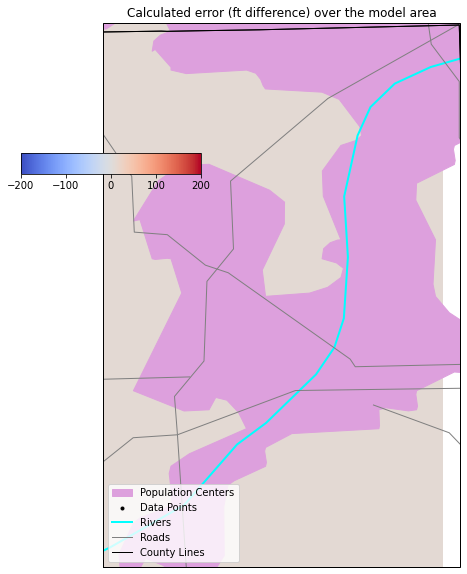

In [38]:
#Create a figure
fig=plt.figure(figsize=(10,10)) #create 10 x 10 figure
#Define a projection
#ax = plt.axes(projection=ccrs.PlateCarree())

#Define the spatial domain to plot
ax.set_xlim(sw_long,ne_long) #The spatial domain spans from minimum longitude to maximum longitude (x-direction)
ax.set_ylim(sw_lat,ne_lat) #The spatial domain spans from minimum longitude to maximum latitude (y-direction)
#Define a title for the plot
ax.set_title('Calculated error (ft difference) over the model area')

#Using CartoPy, import several features from Natural Earth Data (see https://www.naturalearthdata.com/features/)
#Large rivers:
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')
#Small rivers:
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')
#Smallest rivers:
smallestrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_north_america',
    scale='10m',
    facecolor='none')
#Population centers:
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    scale='10m',
    facecolor='plum')
#Major roads:
majorroads = cf.NaturalEarthFeature(
    category='cultural',
    name='roads',
    scale='10m',
    facecolor='none')

# Add the features defined above to the plot, with various colors and markers
ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0) # Population centers will be light purple areas
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0) # Large, small, and smallest rivers will be light blue lines
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(smallestrivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(majorroads,edgecolor='gray',linewidth=1.0) # Roads will be gray lines
ax.add_feature(USCOUNTIES.with_scale('5m'),linewidth=1.0) # County lines will be black lines

#Create contours from the interpolation
error_contour_levels = [-100,-80,-60,-40,-20,0,20,40,60,80] # Set contour levels for contouring error
cset_contour = plt.contour(X,Y,z,error_contour_levels,colors='blue')

#Add in a continuous color flood
cset_fill=plt.imshow(z,vmin=-200,vmax=200,cmap=plt.cm.coolwarm,origin='lower',extent=[X.min(), X.max(), Y.min(), Y.max()])

#The following code could also be used, if a discrete color flood is preferred:
#cset_fill = plt.contourf(X,Y,z,vmin=-100,vmax=100,cmap=plt.cm.coolwarm)

#Label contours (makes use of pylab)
pylab.clabel(cset_contour, inline=1, fontsize=10,fmt='%1.0f')

#Plot the points that were measured
points=plt.scatter(pumping_ob['long'], pumping_ob['lat'], marker=".", color="black", label="Data Points")

#Add a legend to the plot
cities_towns=mpatches.Patch(color='plum',label='Population Centers') #Create a proxy artist to represent population centers on the legend
rivers=mlines.Line2D([],[],linewidth=2.0,color='aqua',label='Rivers') #Proxy artist for large and small rivers
roads=mlines.Line2D([],[],linewidth=1.0,color='gray',label='Roads') #Proxy artist for major roads
counties=mlines.Line2D([],[],linewidth=1.0,color='black',label='County Lines') #Proxy artist for county lines
ax.legend(loc='lower left',handles=[cities_towns,points,rivers,roads,counties])

#Add in a colorbar
cax = fig.add_axes([0.15, 0.67, 0.25, 0.03])
fig.colorbar(cset_fill, cax=cax, orientation='horizontal')
plt.show()

In [0]:
#pumping_ob
print(pumping_ob.error.min())
print(pumping_ob.error.max())


In [0]:
z

# 7 Zone Budget

In [0]:
'''Extract binary data from budget files'''
#----------------------------------------------------------------------------
# read the cell budget file, a binary output file of the model
cbc_f = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#cbc_f.list_records()

# import a zone input file
# the zone input file is a text file that assigns a zone to each cell in the model
uploaded = files.upload()
zon = flopy.utils.zonbud.read_zbarray('zone_file.txt') #read_zbarray is used to read in the zone input file as an array

del uploaded

# create a ZoneBudget object and get the budget record array
zb = flopy.utils.ZoneBudget(cbc_f, zon, kstpkper=(0, 0)) #kstpkper specifies the timestep and stress period of interest
zb.get_budget()
#zb.get_record_names()